# Machine Learning - Practical 1 - Linear Regression

Names: Joshua Wilkinson  |      Ilia Leonov    |    Hoai Son Bien 

Summer Term 2024   

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Work in groups of three and hand in your solution as a group.

- Solutions need to be uploaded to StudIP until the submission date indicated in the course plan. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Solutions need to be presented to tutors in tutorial. Presentation dates are listed in the course plan. Every group member needs to be able to explain everything.

- You have to solve N-1 practicals to get admission to the exam.

- For plots you create yourself, all axes must be labeled. 

- Do not change the function interfaces.

## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [3]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [4]:
# data = pd.read_csv('data/superconduct_train.csv')
data = pd.read_csv('superconduct_train.csv')
print(data.shape)

(21263, 82)


In [76]:
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed. This makes the train and test splits same even if you re-run the notebook. Keeping the splits same is important for the fair models comparison.

In [7]:
target_clm = 'critical_temp'  # the critical temperature is our target variable
n_trainset = 200  # size of the training set
n_testset = 500  # size of the test set

In [8]:
# set random seed to make sure every test set is the same
np.random.seed(seed=1)

idx = np.arange(data.shape[0])
idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

test_idx = idx_shuffled[:n_testset]
train_idx = idx_shuffled[n_testset:n_testset+n_trainset]
train_full_idx = idx_shuffled[n_testset:]

X_test_raw = data.loc[test_idx, data.columns != target_clm].values
y_test = data.loc[test_idx, data.columns == target_clm].values
print('Test set shapes (X and y)', X_test_raw.shape, y_test.shape)

X_train_raw = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):', X_train_raw.shape, y_train.shape)

X_train_full_raw = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):', X_train_full_raw.shape, y_train_full.shape)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


## Task 1: Plot the dataset

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatter plots** relating the target variable to one of the feature values. For this you will need 81 scatter plots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

Furthermore, we need to normalize the data, such that each feature has a mean of zero mean and a variance of one. Implement a function `normalize` which normalizes the data. Print the means and standard variation of the first five features before and after.

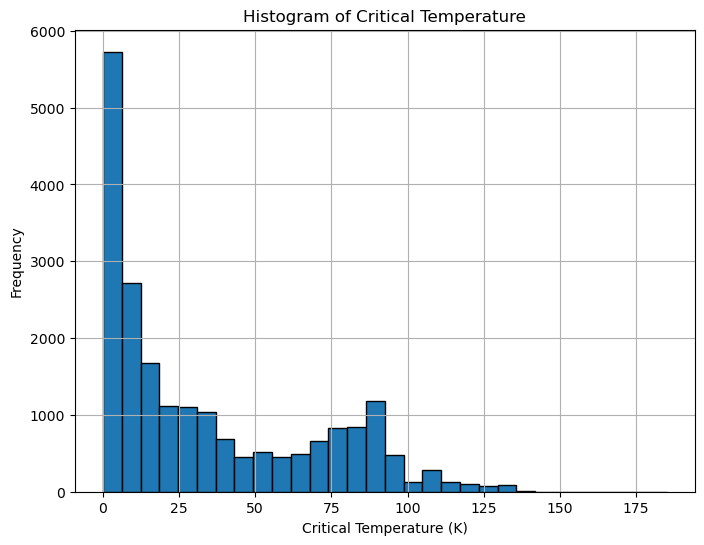

In [109]:
# Histogram of the target variable
plt.figure(figsize=(8, 6))
plt.hist(y_train_full, bins=30, edgecolor='black')
plt.title('Histogram of Critical Temperature')
plt.xlabel('Critical Temperature (K)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

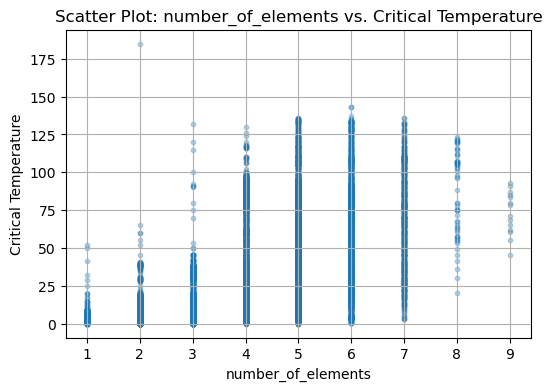

In [80]:
feature_names = data.columns[data.columns != target_clm]

plt.figure(figsize=(6, 4))
plt.scatter(X_train_full_raw[:, 0], y_train_full, alpha=0.3, s=10)
plt.title(f'Scatter Plot: {feature_names[0]} vs. Critical Temperature', fontsize=12)
plt.xlabel(feature_names[0], fontsize=10)
plt.ylabel('Critical Temperature', fontsize=10)
plt.grid(True)
plt.show()

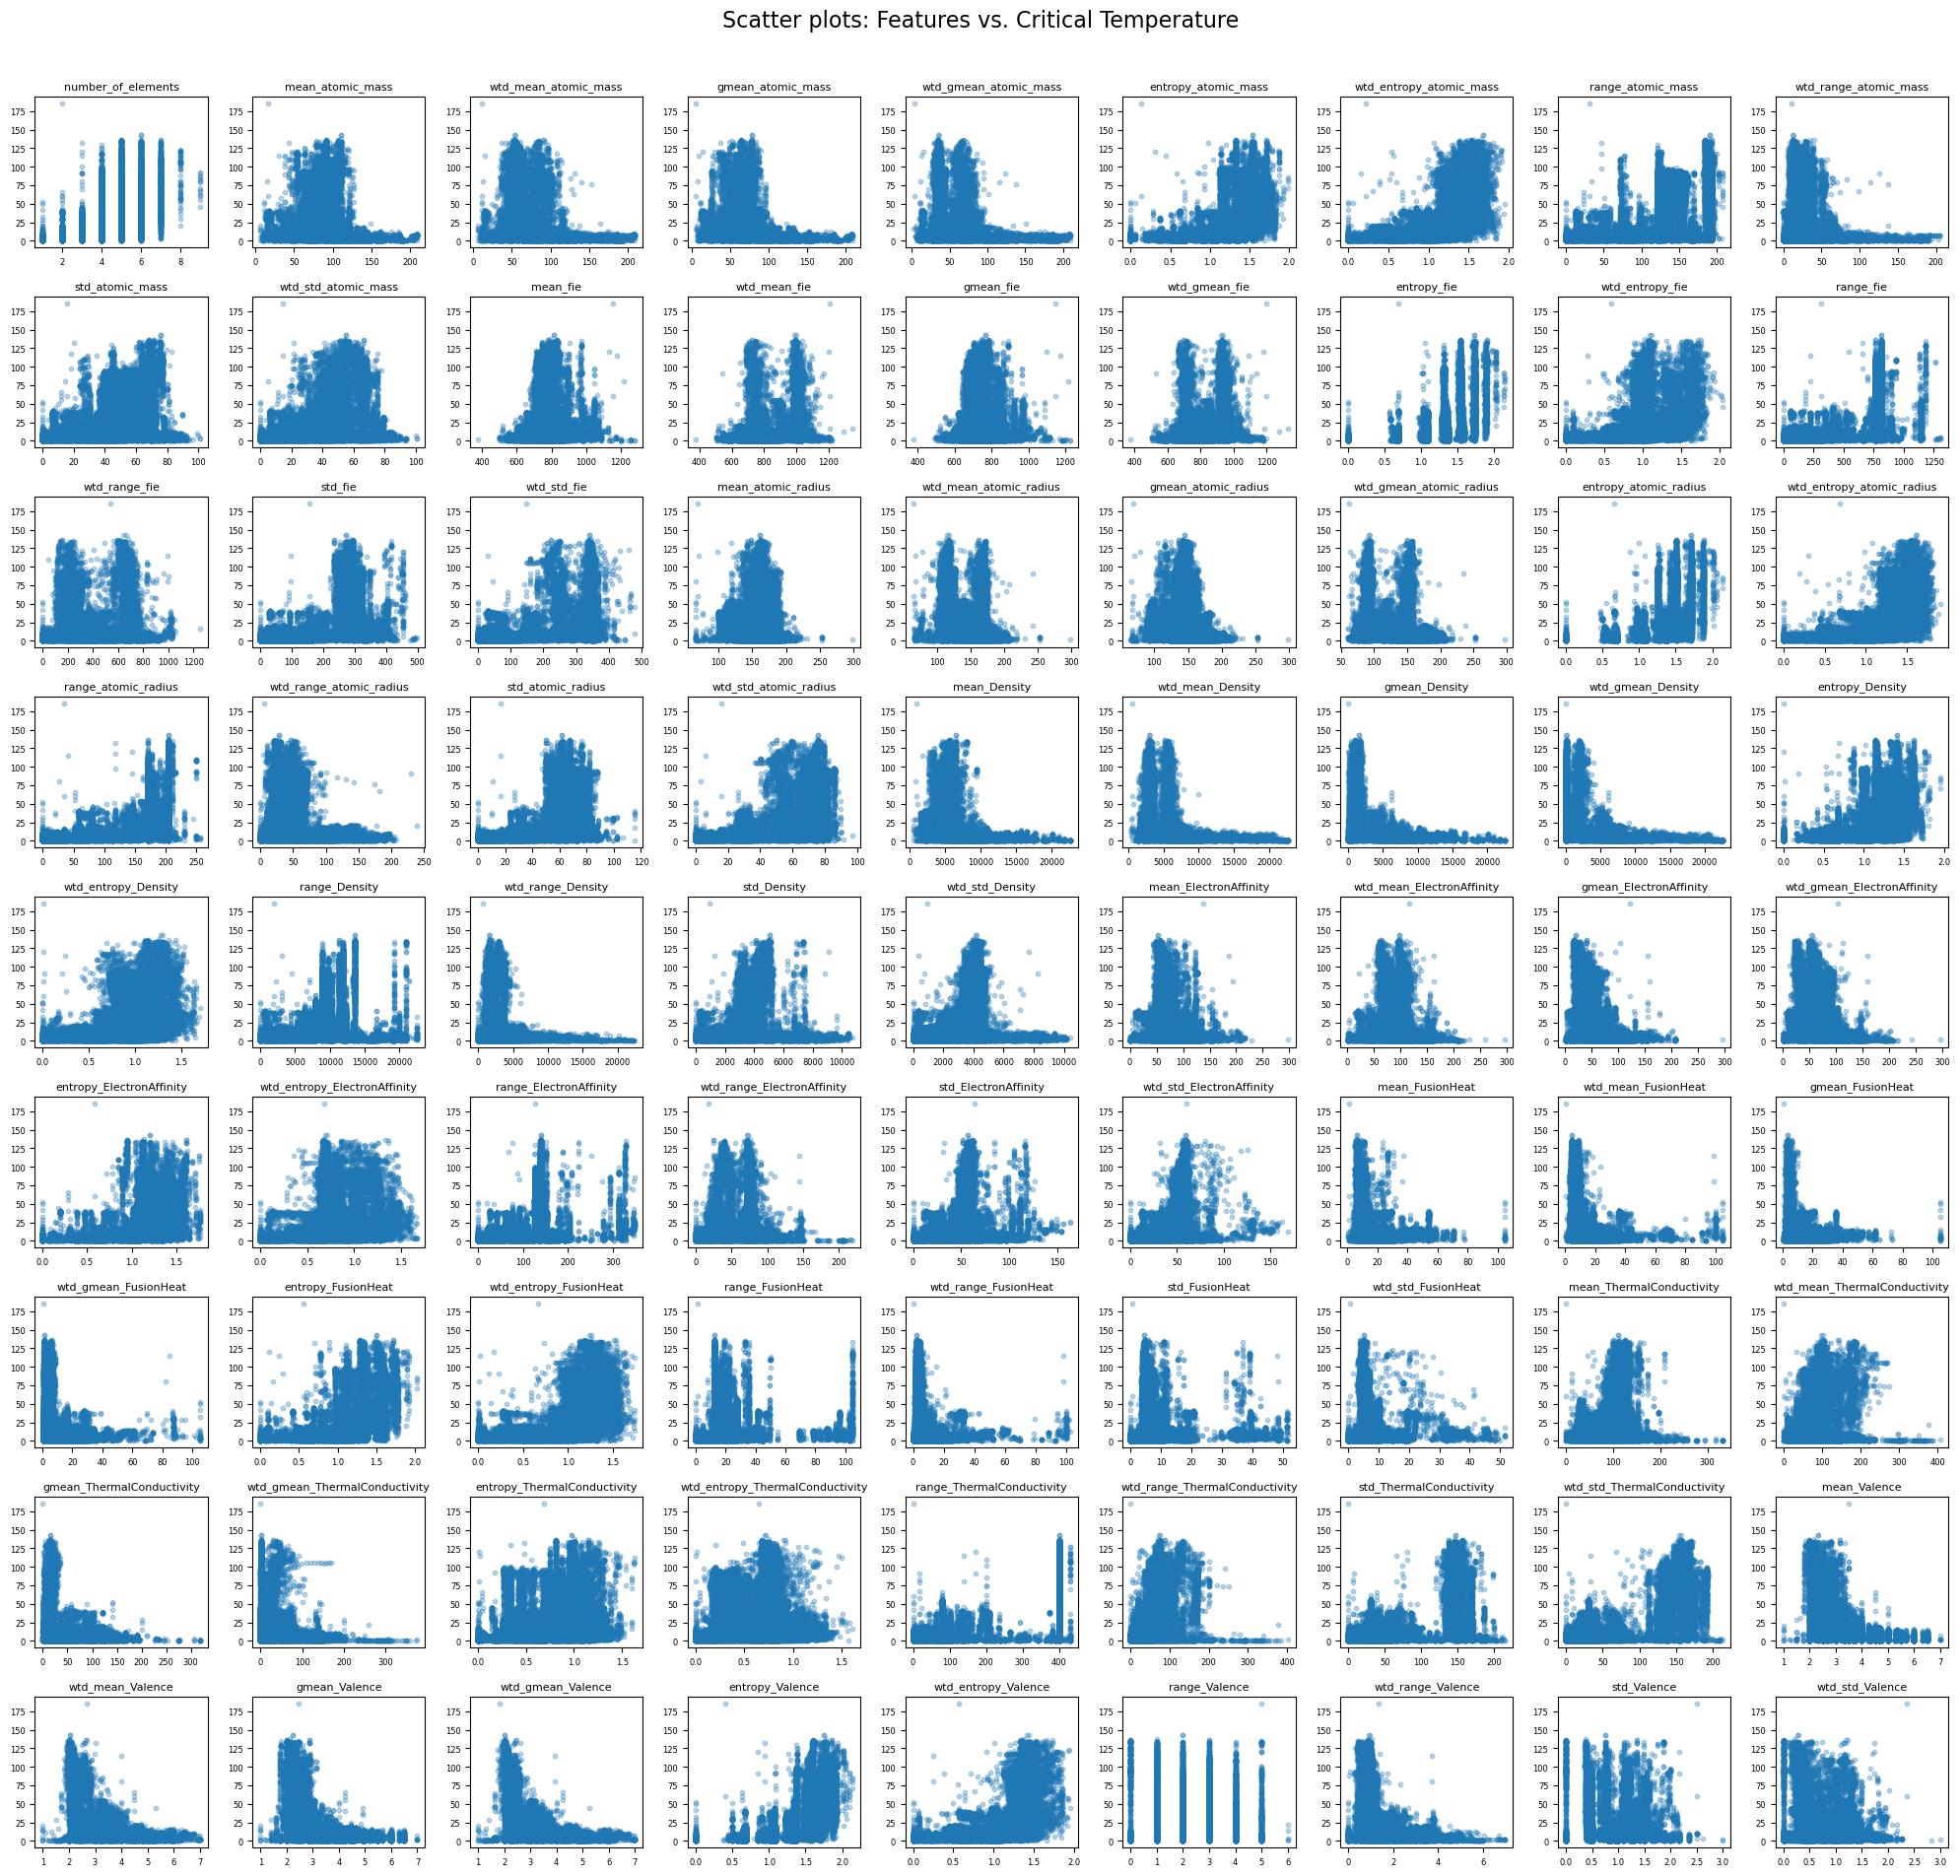

In [81]:
# Scatter plots of the target variable vs. features
# feature_names = data.columns[data.columns != target_clm]
fig, axes = plt.subplots(9, 9, figsize=(20, 20))
fig.suptitle('Scatter plots: Features vs. Critical Temperature', fontsize=16)

for i in range(81):
    row, col = divmod(i, 9)
    ax = axes[row, col]
    ax.scatter(X_train_full_raw[:, i], y_train_full, alpha=0.3, s=10)
    ax.set_title(feature_names[i], fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [82]:
# Normalize
def normalize(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    return (X - means) / stds, means, stds

print("Before normalization:")
for i in range(5):
    print(f"Feature {i} mean: {X_train_full_raw[:, i].mean():.4f}, std: {X_train_full_raw[:, i].std():.4f}")

# Normalize the training data
X_train_full_norm, means, stds = normalize(X_train_full_raw)

# Print stats after normalization (first 5 features)
print("\nAfter normalization:")
for i in range(5):
    print(f"Feature {i} mean: {X_train_full_norm[:, i].mean():.4f}, std: {X_train_full_norm[:, i].std():.4f}")

Before normalization:
Feature 0 mean: 4.1122, std: 1.4396
Feature 1 mean: 87.6081, std: 29.7030
Feature 2 mean: 73.0499, std: 33.5624
Feature 3 mean: 71.3426, std: 31.0756
Feature 4 mean: 58.6034, std: 36.7321

After normalization:
Feature 0 mean: -0.0000, std: 1.0000
Feature 1 mean: -0.0000, std: 1.0000
Feature 2 mean: 0.0000, std: 1.0000
Feature 3 mean: 0.0000, std: 1.0000
Feature 4 mean: -0.0000, std: 1.0000


Which material properties may be useful for predicting superconductivity? What other observations can you make?

Every features seems to show some correlation with critical temperature except: range_atomic_mass, std_atomic_mass, range_Valence, entropy_Density, wtd_entropy_Density, wtd_entropy_ElectronAffinity, wtd_mean_ThermalConductivity, entropy_ThermalConductivity, wtd_entropy_ThermalConductivity, std_Valence, wtd_std_valence, entropy_FusionHeat. Scatter plots not always show linear relationship, but some also show nonlinear relationship.

## Task 2:  Implement your own OLS estimator

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [18]:
def plot_regression_results(y_test, y_pred, weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram

    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''

    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('r^2: ', r2_score(y_test, y_pred))

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    # predicted vs true
    ax[0].scatter(y_test, y_pred, s=2)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    # residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error), bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    # weight histogram
    ax[2].hist(weights, bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()
    plt.show()

As an example, we here show you how to use this function with random data. 

MSE:  17928.79570726673
r^2:  -13.313953173396845


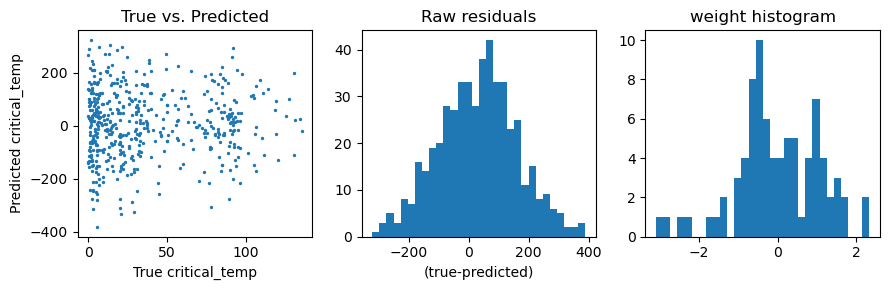

In [19]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_testing = np.random.randn(y_test.size) * np.max(y_test)

plot_regression_results(y_test, y_pred_testing, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights and compute the MSE and $r^2$ from `X_test`. When you call our plotting function with the regression result, you should get mean squared error of 707.8.

In [85]:
def ols_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------

    # Add intercept term (column of 1's) to the training and test sets
    def add_intercept(X):
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))

    # Perform OLS calculation: w = (X^T X)^(-1) X^T y
    X_train_b = add_intercept(X_train)  # Add intercept to training set
    weights = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train  # Compute the weights

    # Predict on the test set
    X_test_b = add_intercept(X_test)  # Add intercept to test set
    y_pred = X_test_b @ weights  # Predictions on the test set

    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  599.7397624928968
r^2:  0.5211810644332333


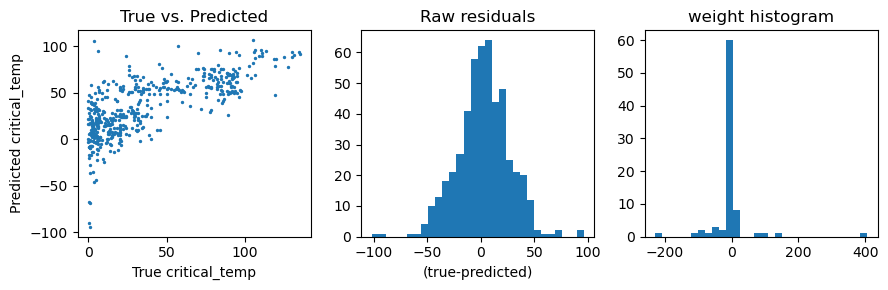

In [86]:
# Plots of the results
weights, y_pred = ols_regression(X_test_raw, X_train_raw, y_train)
plot_regression_results(y_test, y_pred, weights)

What do you observe? Is the linear regression model good?

### What do you observe?
- Mean Squared Error: 599.739762528701
- $r^2$: 0.52
- Left plot: visible positive trend but a lot of scatter. Seems to capture the general behaviour, but does poorly for low temp.
- Middle plot: rougly bell shaped, centered slightly left to 0. The spread is pretty wide (mostly between -50 and 50).
- Right plot: most model weights are close to 0, only a few features have large positive or negative weights.
### Is the linear regression model good?
Not really.
- MSE of 599.74 shows the errors are pretty big. By checking the Root Mean Squared Error (RMSE). we get 24.5, so + or - 24.5 degrees off the true value on average. 
- 52% variability, a bit better than random guessing (48% variability not explained).

## Task 3: Compare your implementation to sklearn

Now, familiarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [11]:
from sklearn.linear_model import LinearRegression

In [23]:
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------

    # Step 1: Create and fit the model
    model = LinearRegression().fit(X_train, y_train)
    weights = model.coef_

    # Step 2: Predict on the test set
    y_pred = model.predict(X_test)

    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  599.7397626182969
r^2:  0.5211810643331167


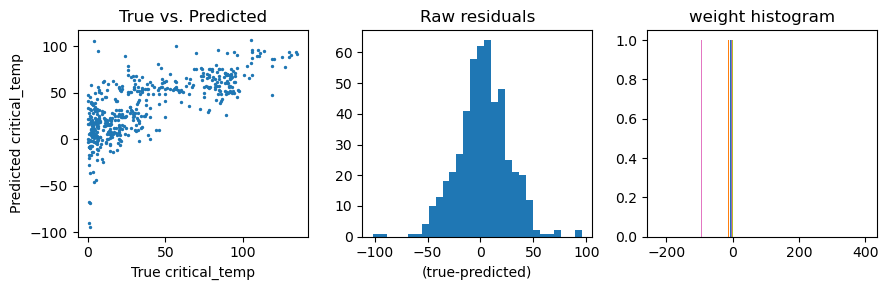

In [24]:
weights, y_pred = sklearn_regression(X_test_raw, X_train_raw, y_train)
plot_regression_results(y_test, y_pred, weights)

If you implemented everything correctly, the MSE is again 707.8.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  329.8607010410739
r^2:  0.7366465263178792


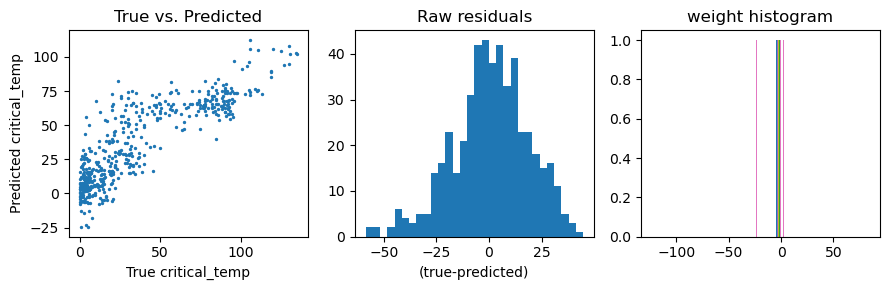

In [25]:
weights, y_pred = sklearn_regression(X_test_raw, X_train_full_raw, y_train_full)
plot_regression_results(y_test, y_pred, weights)

 How does test set performance change? What else changes?

Increasing the volume of training set makes the prediction to be more precise. The tail of the (true-predicted) distribution is shorter indicating smaller difference and there are also less unreasonable large weight.

## Task 4: Regularization with ridge regression

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [91]:
from sklearn.linear_model import Ridge

def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha
       on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regression model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------

    # Compute (X^T X + alpha * I)
    n_features = X_train.shape[1]
    I = np.eye(n_features)
    
    # Important: do NOT regularize the bias term (column of 1s), so set I[0, 0] = 0
    I[0, 0] = 0

    # Compute weights using the closed-form ridge regression solution
    XtX = X_train.T @ X_train
    Xty = X_train.T @ y_train
    weights = np.linalg.inv(XtX + alpha * I) @ Xty

    # Predict on test set
    y_pred = X_test @ weights

    # ---------------- END CODE -------------------------

    return weights, y_pred

Run the ridge regression on `X_train` with an alpha value of 10 and plot the obtained weights.

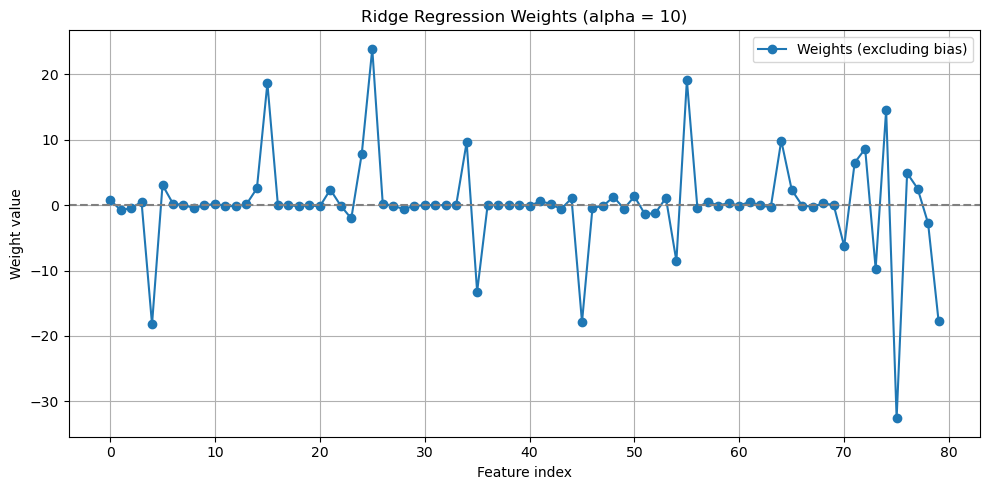

In [92]:
# Run ridge regression with alpha=10
alpha = 10
weights, y_pred = ridge_regression(X_test_raw, X_train_full_raw, y_train_full, alpha)

# Plot regression results
plt.figure(figsize=(10, 5))
plt.plot(weights[1:], marker='o', linestyle='-', label='Weights (excluding bias)')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Ridge Regression Weights (alpha = {alpha})')
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now test a range of log-spaced $\alpha\text{s}$ (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.


In [93]:
alphas = np.logspace(-7, 7, 20)

# ---------------- INSERT CODE ----------------------

all_weights = []
test_errors = []
for alpha in alphas:
    weights, y_pred = ridge_regression(X_test_raw, X_train_raw, y_train, alpha)
    all_weights.append(weights)
    
    mse = mean_squared_error(y_test, y_pred)  # Assuming y_test is defined
    test_errors.append(mse)

# ---------------- END CODE -------------------------

Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

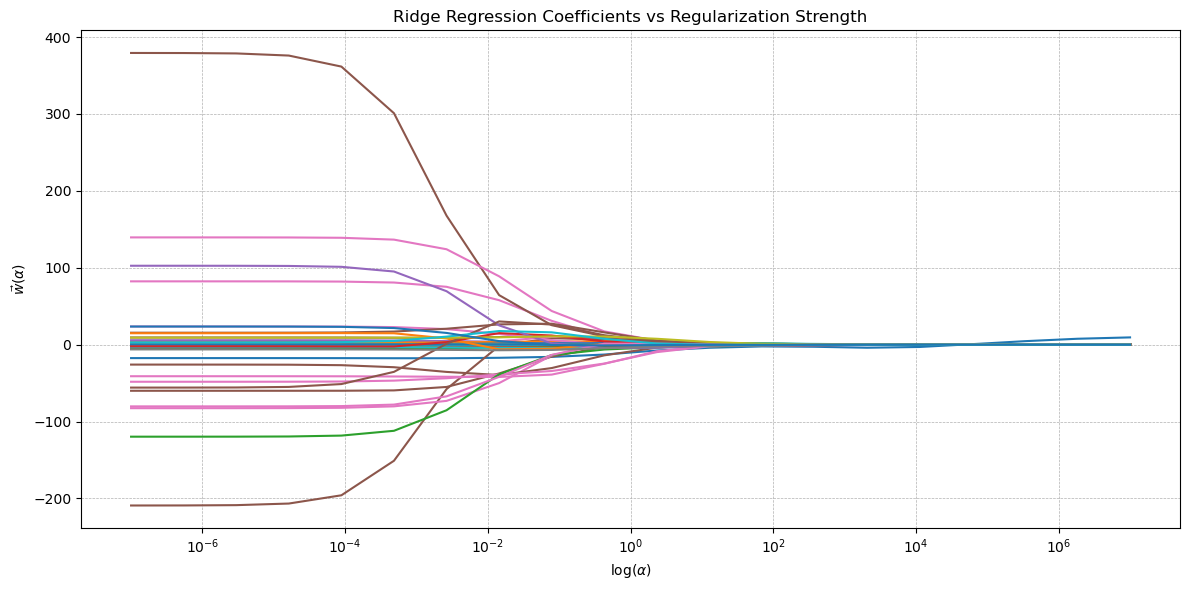

In [94]:
# Plot of coefficients vs. alphas

# Convert list of weight arrays to a 2D array: shape (n_alphas, n_features)
all_weights_array = np.array(all_weights)  # shape: (20, n_features)

# Plot
plt.figure(figsize=(12, 6))
for i in range(all_weights_array.shape[1]):
    plt.plot(alphas, all_weights_array[:, i], label=f'Weight {i}')

plt.xscale('log')
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel(r"$\vec{w}(\alpha)$")
plt.title('Ridge Regression Coefficients vs Regularization Strength')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Why are the values of the weights largest on the left? Do they all change monotonically? 

### Why are the values for the weights largest on the left?
The regularization strength $\alpha$ affects the diagonal terms of $X^T X$ and, therefore, increases the eigenvalues. Sometimes, there is very small eigenvalues and that makes the numerical error by inversing $X^T X$ become very large. By balancing the eigenvalues with $\alpha$, we lower the amplitude of weights calculated. Hence, the value of weights at the smallest $\alpha$ will be largest and converge to around $0$, when we increase $\alpha$.

### Do the weights all change monotonically?
Not necessarily. Some weights do decrease monotonically towards zero as the alpha value increases, but others may increase slightly before shrinking (especially when there is collinearity between features or if a weight's influence is swapped out as regularisation increases). Ridge regression balances fit against simplicity; sometimes a weight becomes more active at intermediate alphas before decreasing again.

Plot how the performance (i.e. the error) changes as a function of $\alpha$. As a sanity check, the MSE value for very small $\alpha$ should be close to the test-set MSE of the unregularized solution, i.e. 708.

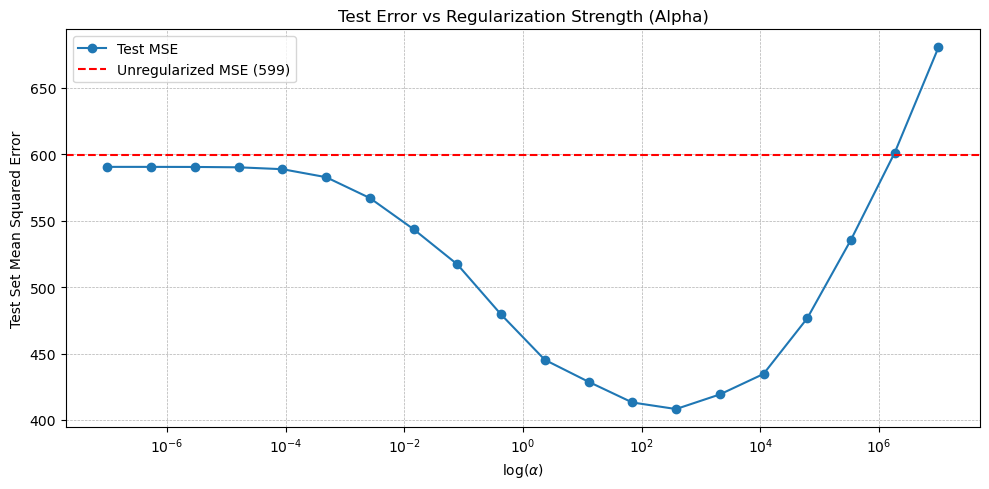

In [95]:
# Plot of MSE  vs. alphas

# Plot test error vs alpha
plt.figure(figsize=(10, 5))
plt.plot(alphas, test_errors, marker='o', linestyle='-', label='Test MSE')

# Add a horizontal line for the unregularized baseline MSE
plt.axhline(y=599, color='red', linestyle='--', label='Unregularized MSE (599)')

plt.xscale('log')
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel('Test Set Mean Squared Error')
plt.title('Test Error vs Regularization Strength (Alpha)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~700 on the left?

YOUR ANSWER HERE

### Which value of alpha gives the minimum MSE?
$\alpha_{MSEmin} \approx 379.26901907$

### Is it better than the unregularised model?
It is not really better than the unregularized model, since at some $\alpha$, the eigenvalues can be too large and makes all weights be around $0$. In this case, the Ridge regression is biased and ignores most of the data
### Why should the cureve reach ~700 on the right
When $\alpha$ is that large to the right, it is completely biased. Hence, what we predicted is much more different than the data.

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [96]:
def ridge_regression_sklearn(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------

    model = Ridge(alpha=alpha, fit_intercept=True)
    model.fit(X_train, y_train)

    # Include intercept as first element (scalar)
    weights = np.append(model.intercept_, model.coef_)
    
    y_pred = model.predict(X_test)

    # ---------------- END CODE -------------------------

    return weights, y_pred

This time, only plot how the performance changes as a function of $\alpha$. 

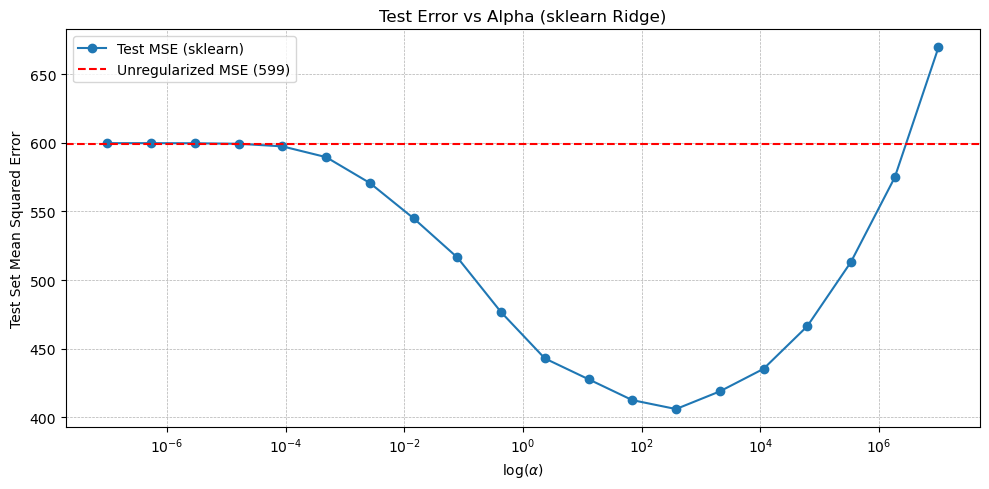

In [97]:
# Plot of MSE  vs. alphas

test_errors_sklearn = []

for alpha in alphas:
    weights, y_pred = ridge_regression_sklearn(X_test_raw, X_train_raw, y_train, alpha)
    mse = mean_squared_error(y_test, y_pred)
    test_errors_sklearn.append(mse)

plt.figure(figsize=(10, 5))
plt.plot(alphas, test_errors_sklearn, marker='o', linestyle='-', label='Test MSE (sklearn)')

plt.axhline(y=599, color='red', linestyle='--', label='Unregularized MSE (599)')

plt.xscale('log')
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel('Test Set Mean Squared Error')
plt.title('Test Error vs Alpha (sklearn Ridge)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [98]:
def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha.
       The function should train the linear regression model for each fold on all values of alpha.

      Inputs:
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over

      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold

      Note:
        Fix the seed for reproducibility.
    '''

    cv_results_mse = np.zeros((n_folds, len(alphas)))
    np.random.seed(seed=2)

    # ---------------- INSERT CODE ----------------------

    cv_results_mse = np.zeros((n_folds, len(alphas)))  # Store MSE for each fold and alpha
    np.random.seed(seed=2)  # Fix seed for reproducibility

    # Perform KFold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=2)

    # Iterate over all folds
    fold_idx = 0
    for train_idx, val_idx in kf.split(X):
        # Split data into train and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # For each alpha, fit the model and compute MSE
        for alpha_idx, alpha in enumerate(alphas):
            # Get weights and predictions using ridge regression with sklearn
            weights, y_pred = ridge_regression_sklearn(X_val, X_train, y_train, alpha)
            
            # Compute the MSE for this fold and alpha
            mse = mean_squared_error(y_val, y_pred)
            cv_results_mse[fold_idx, alpha_idx] = mse

        fold_idx += 1

    # ---------------- END CODE -------------------------

    return cv_results_mse

In [99]:
from sklearn.model_selection import KFold

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [100]:
alphas = np.logspace(-7, 7, 100)
mse_cv = ridgeCV(X_train_raw, y_train, n_folds=10, alphas=alphas)

We plot the MSE trace for each fold separately:

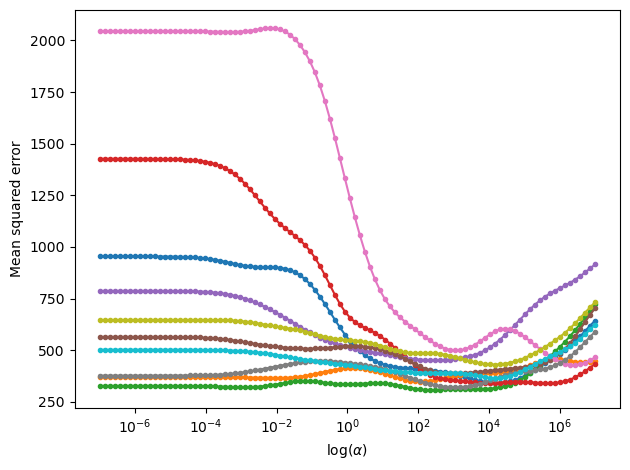

In [101]:
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.show()

We also plot the average across folds:

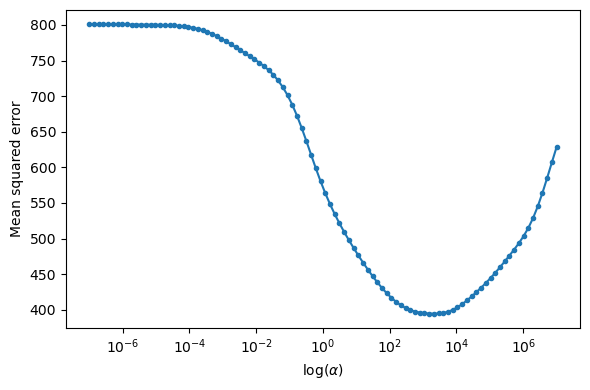

In [102]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.show()

In [103]:
mmse_cv = np.mean(mse_cv, axis=0)
alphas[mmse_cv == min(mmse_cv)]

array([2104.90414451])

What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

$\alpha_{MSEmin} \approx 2104.90414451$ <br>
Qualitatively speaking, they look the same, but the cross-validation MSE has larger value for small $\alpha$ and the far left values also smaller than test-set MSE. The optimal $\alpha$ is also shifted to the right.

We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).

In [104]:
alphas = np.logspace(-7, 7, 100)
mse_cv_full = ridgeCV(X_train_full_raw, y_train_full, n_folds=10, alphas=alphas)

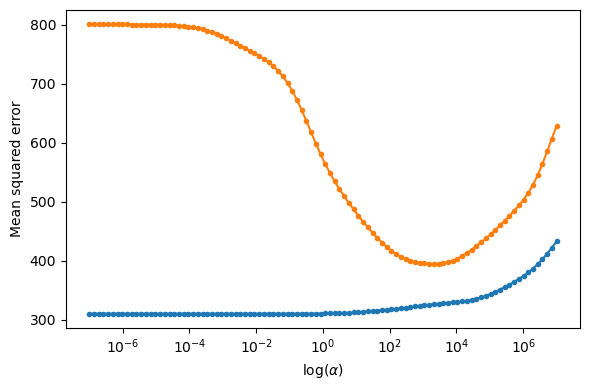

In [105]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.show()

We zoom in on the blue curve to the very left:

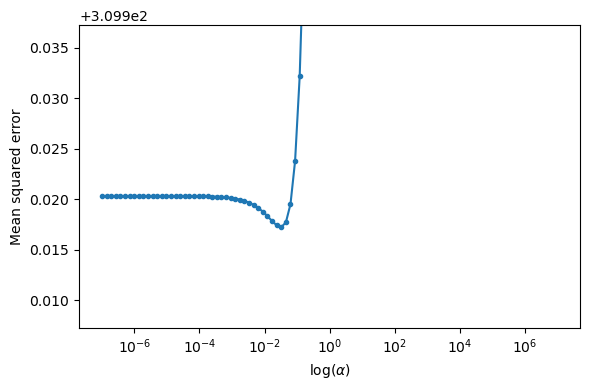

In [106]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full, axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel(r'$\log(\alpha)$')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.show()

In [107]:
mmse_cv_full = np.mean(mse_cv_full, axis = 0)
alphas[mmse_cv_full == min(mmse_cv_full)]

array([0.03274549])

Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

The MSE values of CV curve are much smaller on the full data set, since we have to split the training data by using CV, which makes the set even smaller if we take the small data set. Hence, the model learns poorly and not reliable in this case.<br>
$\alpha_{MSEmin} \approx 0.03274549$ <br>
The $\alpha$ is much smaller than on the small training set. Indeed, due to limited training data set, it needs stronger regulation to reach the smallest MSE, while the MSE for full training set has been already small thanks to big data set, so the optimal $\alpha$ will be much smaller.